\begin{align}
Y_t &= f(\beta_t X_t) \\
\beta_t &\sim \mathcal{N}(\beta_{t-1}, s^2)
\end{align}

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn.datasets

from scipy import VisibleDeprecationWarning
from sklearn.preprocessing import scale

warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_style('white')
sns.set_context('notebook')

In [2]:
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1)
X = scale(X)
colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0] + 1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)

In [3]:
import base64

from tempfile import NamedTemporaryFile

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""


def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("test.mp4", fps=20, extra_args=['-vcodec', 'libx264'])
        video = open("test.mp4","rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


ims = [] #l, = plt.plot([], [], 'r-')
for i in np.arange(0, len(X), 10):
    ims.append([(plt.scatter(X[:i, 0], X[:i, 1], color=colors[:i]))])
plt.xlabel('X1')
plt.ylabel('X2')
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = ArtistAnimation(plt.gcf(), ims, interval=500, blit=True);

display_animation(anim)

In [4]:
import theano
import theano.tensor as tt

from pymc3 import HalfNormal, GaussianRandomWalk, Bernoulli
from pymc3.math import sigmoid

# The interval used for generating the dataset is 20.
# Does changing the interval used for inference make a difference?
interval = 50

X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

n_dim = X.shape[1] # 2

with pm.Model() as random_walk_perceptron:
    step_size = pm.HalfNormal('step_size', sd=np.ones(n_dim), 
                              shape=n_dim)
    
    # This is the central trick, PyMC3 already comes with this distribution
    w = pm.GaussianRandomWalk('w', sd=step_size, 
                              shape=(interval, 2))
    
    weights = tt.repeat(w, X_shared.shape[0] // interval, axis=0)
    
    class_prob = sigmoid(tt.batched_dot(X_shared, weights))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('out', class_prob, observed=Y_shared)

In [5]:
with random_walk_perceptron:
    trace_perceptron = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 154.79:   9%|▉         | 17983/200000 [00:07<01:17, 2351.20it/s]
Convergence archived at 18000
Interrupted at 18,000 [9%]: Average Loss = 344.46
100%|██████████| 2500/2500 [02:44<00:00, 15.23it/s]


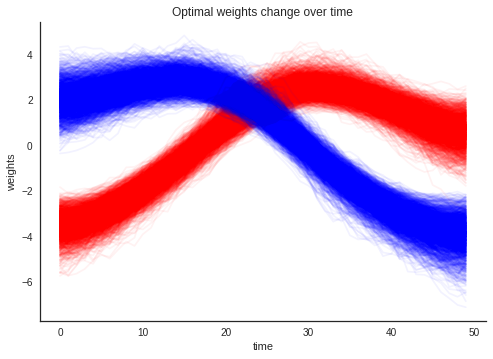

In [6]:
plt.plot(trace_perceptron['w'][:, :, 0].T, alpha=.05, color='r')
plt.plot(trace_perceptron['w'][:, :, 1].T, alpha=.05, color='b')
plt.xlabel('time')
plt.ylabel('weights')
plt.title('Optimal weights change over time')
sns.despine()

In [7]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

X_shared.set_value(grid_2d)
Y_shared.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace_perceptron, model=random_walk_perceptron, samples=500)

def create_surface(X, Y, grid, ppc, fig=None, ax=None):
    artists = []
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour = ax.contourf(*grid, ppc, cmap=cmap)
    artists.extend(contour.collections)
    artists.append(ax.scatter(X[Y==0, 0], X[Y==0, 1], color='b'))
    artists.append(ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r'))
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
    return artists

100%|██████████| 500/500 [01:01<00:00,  8.29it/s]


In [8]:
fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)
    
anim2 = ArtistAnimation(fig, axs, interval=1000);
display_animation(anim2)